[980, 1135, 1924, 1010, 982, 0, 958, 1028, 974, 1009]

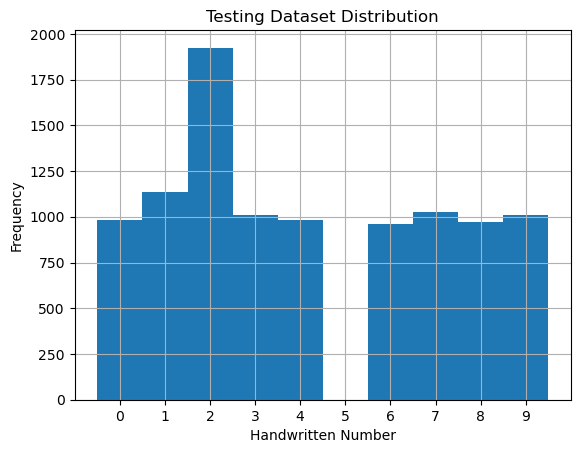

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from model import LeNet5
from dataloader import MNISTDataLoader


my_data = MNISTDataLoader()

my_dist = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
my_data.sample_bias(my_dist, dataset="train", dist_is_freq=True)
# my_data.plot_dist(dataset="train")

my_data.corrupt_targets(5, 2, freq_corrupt=1.0, dataset="test")
my_data.plot_dist(dataset="test")
my_data.get_curr_dist(dataset="test")

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torchvision
import matplotlib.pyplot as plt
# from torchviz import make_dot

from model import LeNet5
from meta_model import MetaModule, LeNet
from dataloader import MNISTDataLoader 

torch.backends.cudnn.enabled = False
torch.manual_seed(1)

class NoReweighting():
    def __init__(self, network, hyperparameters, criterion, optimizer, train_loader, test_loader):
        self.network = network
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        # Train the network
        for epoch in range(hyperparameters['n_epochs']):
            self.network.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                self.optimizer.zero_grad()
                output = self.network(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                if batch_idx % hyperparameters['log_interval'] == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))

        # Test the network
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            self.network.eval()
            output = self.network(data)
            test_loss += self.criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        print('\nTest set: \nAvg. loss: {:.4f} \nAccuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

class NaiveReweighting():
    def __init__(self, network, hyperparameters, criterion, optimizer, train_loader, test_loader):
        self.network = network
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
    # TODO:

class NoReweighting():
    def __init__(self, network, hyperparameters, criterion, optimizer, train_loader, test_loader):
        self.network = network
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        # Train the network
        for epoch in range(hyperparameters['n_epochs']):
            self.network.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                self.optimizer.zero_grad()
                output = self.network(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                if batch_idx % hyperparameters['log_interval'] == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))

        # Test the network
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            self.network.eval()
            output = self.network(data)
            test_loss += self.criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        print('\nTest set: \nAvg. loss: {:.4f} \nAccuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

class NaiveReweighting():
    def __init__(self, network, hyperparameters, criterion, optimizer, train_loader, test_loader):
        self.network = network
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
    # TODO:

class Reweighting():
    def __init__(self, network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, test_loader):
        self.network = network.requires_grad_(requires_grad=True)
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion_mean = criterion_mean

    def train(self):
        # X_g = LeNet5()
        # print("Starting training...")
        X_g, y_g = next(iter(self.train_loader))
        # X_g = X_g.requires_grad_(requires_grad=True)
        # Train the network
        y_f_hat = torch.empty(1)

        theta_tp1 = self.network.state_dict()
        for i in range(self.hyperparameters['n_epochs']):
            # print("Epoch loop")
            self.network = LeNet(n_out=10)
            self.network.load_state_dict(theta_tp1)
            
            # for param in theta_tp1:
            #     param.grad = None
            # self.network.our_update_params(theta_tp1)

            # self.network.detach_params()
            # self.network.our_update_params(self.network.params())
            # self.network.copy(self.network, same_var=False)

            self.network.zero_grad()        #zero out any previously accumulated gradient before doing autograd

            self.network.train()
            # get batch of data from train_loader
            X_f, y_f = next(iter(self.train_loader))
            # print("X_f", X_f.size())

            # TODO: get batch of data from validation_loader (it is currently fixed outside the loop)

            # Line 4
            y_f_hat = y_f_hat.detach()
            # make_dot(y_f_hat).render("y_f_hat", format="png")
            y_f_hat = self.network(X_f)
            

            # Line 5
            epsilon = torch.zeros(y_f.size(), requires_grad=True)
            Costs = self.criterion(y_f_hat, y_f)
            l_f = torch.sum(torch.mul(Costs, epsilon))
            # l_f = torch.sum(Costs * epsilon)
            # make_dot(l_f).render("l_f", format="png")
            

            # Line 6
            grad_t = torch.autograd.grad(outputs=l_f, inputs=self.network.params(), create_graph=True)
            # grad_t = torch.autograd.grad(l_f, self.network.parameters(), only_inputs=True)
            # make_dot(grad_t).render("grad_t", format="png")
            

            # Line 7: manually update the weights of the validation network
            theta_t = self.network.params()

            lr = self.hyperparameters['learning_rate']
            self.network.our_update_params_with_step(lr, grad_t)

            # Line 8
            # Model has theta_hat
            y_g_hat = self.network(X_g)

            # Line 9
            l_g = self.criterion_mean(y_g_hat, y_g)
            # make_dot(l_g).render("want_big_graph", format="png")
            # print(y_g_hat)

            # Line 10
            grad_epsilon = torch.autograd.grad(l_g, epsilon, only_inputs=True)[0]
            # make_dot(grad_epsilon).render("grad_epsilon", format="png")

            # Line 11
            w_tilde = torch.clamp(grad_epsilon, min=0)

            if torch.sum(w_tilde) != 0:
                w = w_tilde / torch.sum(w_tilde)
            else:
                w = w_tilde

            # Line 12
            l_f_hat = torch.sum(torch.mul(Costs, w))
            print("l_f_hat", l_f_hat.item())
            self.optimizer.zero_grad()

            # Line 13
            
            self.network.our_update_params(theta_t)
            l_f_hat.backward()

            # Line 14
            self.optimizer.step()
            # break

            theta_tp1 = self.network.state_dict()

            
                
network = LeNet(n_out=10)

hyperparameters = {
    'n_epochs' : 8000,
    'batch_size_train' : 100,
    'batch_size_test' : 1000,
    'learning_rate' : 1e-3,
    'momentum' : 0.5,
    'log_interval' : 10
}

criterion = nn.CrossEntropyLoss(reduction='none')
# criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_mean = nn.CrossEntropyLoss(reduction='mean')
# criterion_mean = nn.BCEWithLogitsLoss(reduction='mean')

optimizer = optim.SGD(network.params(),
                        lr=hyperparameters['learning_rate'],
                        momentum=hyperparameters['momentum'])
# Load the data
data_loader = MNISTDataLoader(batch_size_train=hyperparameters['batch_size_train'],
                                batch_size_test=hyperparameters['batch_size_test'])
train_loader = data_loader.train_dataloader
test_loader = data_loader.test_dataloader

# NoReweighting(network, hyperparameters, criterion, optimizer, train_loader, test_loader).train()
# NaiveReweighting(network, hyperparameters, criterion, optimizer, train_loader, test_loader).train()
Reweighting(network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, test_loader).train()



l_f_hat 2.3242411613464355
l_f_hat 2.3217854499816895
l_f_hat 2.315406322479248
l_f_hat 2.332038640975952
l_f_hat 2.327238082885742
l_f_hat 2.3230910301208496
l_f_hat 2.3088366985321045
l_f_hat 2.3225326538085938
l_f_hat 2.299659013748169
l_f_hat 2.3053503036499023
l_f_hat 2.3300840854644775
l_f_hat 2.2957170009613037
l_f_hat 2.3306405544281006
l_f_hat 2.303028106689453
l_f_hat 2.3026282787323
l_f_hat 2.317584991455078
l_f_hat 2.3102593421936035
l_f_hat 2.321739435195923
l_f_hat 2.3162500858306885
l_f_hat 2.314568281173706
l_f_hat 2.3102641105651855
l_f_hat 2.3309311866760254
l_f_hat 2.3120129108428955
l_f_hat 2.3194522857666016
l_f_hat 2.321934223175049
l_f_hat 2.3292956352233887


KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torchvision
from torchviz import make_dot
import matplotlib.pyplot as plt
# from torchviz import make_dot

from model import LeNet5
from meta_model import MetaModule, LeNet
from dataloader import MNISTDataLoader 

torch.backends.cudnn.enabled = False
torch.manual_seed(1)

class NoReweighting():
    def __init__(self, network, hyperparameters, criterion, optimizer, train_loader, test_loader):
        self.network = network
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        # Train the network
        for epoch in range(hyperparameters['n_epochs']):
            self.network.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                self.optimizer.zero_grad()
                output = self.network(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                if batch_idx % hyperparameters['log_interval'] == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))

        # Test the network
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            self.network.eval()
            output = self.network(data)
            test_loss += self.criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        print('\nTest set: \nAvg. loss: {:.4f} \nAccuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

class NoReweighting():
    def __init__(self, network, hyperparameters, criterion, optimizer, train_loader, test_loader):
        self.network = network
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.test_loader = test_loader

    def train(self):
        # Train the network
        for epoch in range(hyperparameters['n_epochs']):
            self.network.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                self.optimizer.zero_grad()
                output = self.network(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                if batch_idx % hyperparameters['log_interval'] == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))

        # Test the network
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            self.network.eval()
            output = self.network(data)
            test_loss += self.criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        print('\nTest set: \nAvg. loss: {:.4f} \nAccuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

class NaiveReweighting():
    def __init__(self, network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, valid_loader, test_loader):
        self.network = network.requires_grad_(requires_grad=True)
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.criterion_mean = criterion_mean

    def train(self):
        # Outside loop modifies weight tensor
        weight_vec = torch.ones(len(train_loader.dataset)) * 1.0/len(train_loader.dataset)
        weight_vec.requires_grad_()

        # Sample validation dataset
        X_g, y_g = next(iter(self.valid_loader))

        # Sample training dataset
        X_f, y_f = next(iter(self.train_loader))

        theta_tp1 = self.network.state_dict()
        for epoch in range(self.hyperparameters['n_epochs']):
            # for epoch in range(2):
            self.network = LeNet(n_out=10)
            self.network.load_state_dict(theta_tp1)

            self.network.train()

            # Equation (1)
            make_dot(weight_vec).render("weight_vec", format="png")
            y_f_hat = self.network(X_f)
            Costs = self.criterion(y_f_hat, y_f)
            l_f_hat = torch.sum(torch.mul(Costs, weight_vec))

            grad_t = torch.autograd.grad(outputs=l_f_hat, inputs=self.network.params(), create_graph=True)

            lr = self.hyperparameters['learning_rate']
            self.network.our_update_params_with_step(lr, grad_t)

            # Equation (2)
            y_g_hat = self.network(X_g)
            l_g_hat = self.criterion_mean(y_g_hat, y_g)

            grad_w = torch.autograd.grad(outputs=l_g_hat, inputs=weight_vec, create_graph=True)
            lr = self.hyperparameters['learning_rate']
            weight_vec = weight_vec - lr * grad_w[0]
            weight_vec = torch.clamp(weight_vec, min=0)
            print(max(weight_vec.data).item() - min(weight_vec.data).item())
            
            # Recreate network
            theta_tp1 = self.network.state_dict()

            # Validation testing
            # if (epoch % self.hyperparameters['log_interval'] == 0):
            self.network.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(self.test_loader):
                prediction = self.network(test_img).detach().numpy()
                prediction = np.argmax(prediction, axis=1)
                # print(prediction)
                # print(test_label.detach().numpy())
                tmp = (prediction == test_label.detach().numpy())
                tmp = tmp*1
                acc.append(tmp)

            accuracy = np.concatenate(acc).mean()
            print(np.round(accuracy*100,2))
            # acc_arr = np.array([epoch, accuracy.cpu().numpy()])
            # accuracy_log.append(acc_arr[None])

            ####################################################
            weight_vec = weight_vec.detach()
            weight_vec = weight_vec.requires_grad_()
            ####################################################


        
    # Inside loop performs one epoch

class Reweighting():
    def __init__(self, network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, valid_loader, test_loader):
        self.network = network.requires_grad_(requires_grad=True)
        self.hyperparameters = hyperparameters
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader
        self.criterion_mean = criterion_mean

    def train(self):
        # X_g = LeNet5()
        # print("Starting training...")
        X_g, y_g = next(iter(self.valid_loader))
        # X_g = X_g.requires_grad_(requires_grad=True)
        # Train the network
        y_f_hat = torch.empty(1)

        theta_tp1 = self.network.state_dict()
        for epoch in range(self.hyperparameters['n_epochs']):
            # print("Epoch loop")
            self.network.train()

            self.meta_network = LeNet(n_out=10)
            self.meta_network.load_state_dict(theta_tp1)
            
            # for param in theta_tp1:
            #     param.grad = None
            # self.network.our_update_params(theta_tp1)

            # self.network.detach_params()
            # self.network.our_update_params(self.network.params())
            # self.network.copy(self.network, same_var=False)

            # self.network.zero_grad()        #zero out any previously accumulated gradient before doing autograd

            
            # get batch of data from train_loader
            X_f, y_f = next(iter(self.train_loader))
            # print("X_f", X_f.size())

            # TODO: get batch of data from validation_loader (it is currently fixed outside the loop)

            # Line 4
            # make_dot(y_f_hat).render("y_f_hat", format="png")
            y_f_hat = self.meta_network(X_f)
            

            # Line 5
            epsilon = torch.zeros(y_f.size(), requires_grad=True)
            Costs = self.criterion(y_f_hat, y_f)
            l_f = torch.sum(torch.mul(Costs, epsilon))
            # l_f = torch.sum(Costs * epsilon)
            # make_dot(l_f).render("l_f", format="png")
            

            # Line 6
            grad_t = torch.autograd.grad(outputs=l_f, inputs=self.meta_network.params(), create_graph=True)
            # grad_t = torch.autograd.grad(l_f, self.network.parameters(), only_inputs=True)
            # make_dot(grad_t).render("grad_t", format="png")
            

            # Line 7: manually update the weights of the validation network
            # theta_t = self.meta_network.params()

            lr = self.hyperparameters['learning_rate']
            self.meta_network.our_update_params_with_step(lr, grad_t)

            # Line 8
            # Model has theta_hat
            y_g_hat = self.meta_network(X_g)

            # Line 9
            l_g = self.criterion_mean(y_g_hat, y_g)
            # make_dot(l_g).render("want_big_graph", format="png")
            # print(y_g_hat)

            # Line 10
            grad_epsilon = torch.autograd.grad(l_g, epsilon, only_inputs=True)[0]
            # make_dot(grad_epsilon).render("grad_epsilon", format="png")

            # Line 11
            w_tilde = torch.clamp(-grad_epsilon, min=0)

            if torch.sum(w_tilde) != 0:
                w = w_tilde / torch.sum(w_tilde)
            else:
                w = w_tilde

            # Line 12
            y_f_hat = self.network(X_f)
            Costs = self.criterion(y_f_hat, y_f)
            l_f_hat = torch.sum(torch.mul(Costs, w))
            # print("l_f_hat", l_f_hat.item())

            self.optimizer.zero_grad()

            # Line 13
            l_f_hat.backward()

            # Line 14
            self.optimizer.step()
            # break

            theta_tp1 = self.network.state_dict()

            if (epoch % self.hyperparameters['log_interval'] == 0):
                self.network.eval()

                acc = []
                for itr,(test_img, test_label) in enumerate(self.test_loader):
                    prediction = self.network(test_img).detach().numpy()
                    prediction = np.argmax(prediction, axis=1)
                    # print(prediction)
                    # print(test_label.detach().numpy())
                    tmp = (prediction == test_label.detach().numpy())
                    tmp = tmp*1
                    acc.append(tmp)

                accuracy = np.concatenate(acc).mean()
                print(np.round(accuracy*100,2))
                # acc_arr = np.array([epoch, accuracy.cpu().numpy()])
                # accuracy_log.append(acc_arr[None])



In [51]:
weight_vec = torch.ones(len(train_loader.dataset)) * 1.0/len(train_loader.dataset)
weight_vec.requires_grad_()
weight_vec

loss = torch.sum(torch.mul(2.0, weight_vec))

grad_w = torch.autograd.grad(outputs=loss, inputs=weight_vec, create_graph=True)
weight_vec = weight_vec + 0.01 * grad_w[0]

weight_vec.detach()
weight_vec.requires_grad_()

max(weight_vec.data).item()



0.020999999716877937

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd
import torchvision
import matplotlib.pyplot as plt
import numpy as np
# from torchviz import make_dot

from model import LeNet5
from meta_model import MetaModule, LeNet
from dataloader import MNISTDataLoader


network = LeNet(n_out=10)

hyperparameters = {
    'n_epochs' : 1000,
    'batch_size_train' : 100,
    'batch_size_valid' : 3000,
    'batch_size_test' : 1000,
    'learning_rate' : 1e-2,
    'momentum' : 0.5,
    'log_interval' : 100
}

criterion = nn.CrossEntropyLoss(reduction='none')
# criterion = nn.BCEWithLogitsLoss(reduction='none')
criterion_mean = nn.CrossEntropyLoss(reduction='mean')
# criterion_mean = nn.BCEWithLogitsLoss(reduction='mean')

optimizer = optim.SGD(network.params(),
                        lr=hyperparameters['learning_rate'],
                        momentum=hyperparameters['momentum'])
# Load the data
data_loader = MNISTDataLoader(validation_ratio=0.05,
                              batch_size_train=hyperparameters['batch_size_train'],
                              batch_size_valid=hyperparameters['batch_size_valid'],
                              batch_size_test=hyperparameters['batch_size_test'])

# Add sample bias and corruption to the data
desired_sample_distribution = [100, 100, 100, 100, 100, 100, 100, 100, 100, 20]
data_loader.sample_bias(desired_sample_distribution, dataset="train")
# data_loader.plot_dist(dataset="train")
# data_loader.plot_dist(dataset="valid")
# data_loader.plot_dist(dataset="test")
# print(data_loader.get_num("train"))

train_loader = data_loader.train_dataloader
valid_loader = data_loader.valid_dataloader
test_loader = data_loader.test_dataloader

# NoReweighting(network, hyperparameters, criterion, optimizer, train_loader, test_loader).train()
# NaiveReweighting(network, hyperparameters, criterion, optimizer, train_loader, test_loader).train()
# Reweighting(network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, valid_loader, test_loader).train()


# Load the data
data_loader = MNISTDataLoader(validation_ratio=0.05,
                              batch_size_train=60000,
                              batch_size_valid=hyperparameters['batch_size_valid'],
                              batch_size_test=hyperparameters['batch_size_test'],
                              shuffle=False)

desired_sample_distribution = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
data_loader.sample_bias(desired_sample_distribution, dataset="train", dist_is_freq=False)

train_loader = data_loader.train_dataloader
valid_loader = data_loader.valid_dataloader
test_loader = data_loader.test_dataloader

NaiveReweighting(network, hyperparameters, criterion, criterion_mean, optimizer, train_loader, valid_loader, test_loader).train()




2.8084345103707165e-05
12.69
5.629741644952446e-05
12.81
8.425907435594127e-05


KeyboardInterrupt: 

In [2]:
# Load the data
data_loader = MNISTDataLoader(validation_ratio=0.05,
                              batch_size_train=6000,
                              batch_size_valid=hyperparameters['batch_size_valid'],
                              batch_size_test=hyperparameters['batch_size_test'],
                              shuffle=False)

# Add sample bias and corruption to the data
desired_sample_distribution = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
data_loader.sample_bias(desired_sample_distribution, dataset="train", dist_is_freq=False)

data_loader.plot_dist("train")
# data_loader.train_dataloader.shuffle

for lcv in range(5):
    X_f, y_f = next(iter(data_loader.train_dataloader))
    print(y_f)

for lcv in range(5):
    X_f, y_f = next(iter(data_loader.train_dataloader))
    print(y_f)



NameError: name 'hyperparameters' is not defined